In [ ]:
import json 

import random 
import math
class Field:
    def __init__(self, field):
        self.field = figures
        self.w_width = self.field['main_rectangle'][0][0]
        self.w_length = self.field['main_rectangle'][0][1]
    def __init(self, path):
        with open(path, "r") as f:
            self.field = json.loads(f.read())
        self.w_width = self.field['main_rectangle'][0][0]
        self.w_length = self.field['main_rectangle'][0][1]
        
class Robot(Field):
    def __init__(self, x = 1, y = 0.5, yaw = 0):
 
        self.x = x          # robot's x coordinate
        self.y = y          # robot's y coordinate
        self.orientation = yaw  # robot's orientation
         
        self.x_pred = 0.0
        self.y_pred = 0.0
        self.forward_noise = 0.05   # noise of the forward movement
        self.turn_noise = 0.1      # noise of the turn
        self.sense_noise = 0.3    # noise of the sensing
        
    def set_coord(self, new_x, new_y, new_orientation):
        #if new_orientation < 0 or new_orientation >= 2 * pi:
        #   raise ValueError('Orientation must be in [0..2pi]')

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
        
    def set_noise(self, new_forward_noise, new_turn_noise, new_sense_noise):
 
        self.forward_noise = float(new_forward_noise)
        self.turn_noise = float(new_turn_noise)
        self.sense_noise = float(new_sense_noise)  

    def sense(self):
        z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]*math.cos(landmarks[i][1])) ** 2 
                             + (self.y - landmarks[i][0]*math.sin(landmarks[i][1])) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            z.append(dist)
        #print("z = ", z)
        return z
    
    def sense3(self, landmarks):
        z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 
                             + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            z.append(dist)
        #print("z = ", z)
        return z
    
    def sense2(self, landmarks):
        z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((get_measurements(landmarks,i)[0]) ** 2 
                             + (get_measurements(landmarks,i)[1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            z.append(dist)
        print("z = ", z)
        return z
    
    def move(self, turn, forward):
 

        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi

        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (math.cos(orientation) * dist)
        y = self.y + (math.sin(orientation) * dist)

        # cyclic truncate
        #x %= Field().w_width
        #y %= Field().w_length

        # set particle
        res = Robot()
        res.set_coord(x, y, orientation)
        #res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)

        return res
    
    def gaussian(self, mu, sigma, x):
        #print(mu, sigma, x)
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(-((mu - x) ** 2) / (sigma ** 2)) / math.sqrt(2.0 * math.pi * (sigma ** 2))
    
    def get_measurements(self):
        print(self.sense())
        return self.sense()
    
    def measurement_prob(self, measurement):
        prob = 1.0
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            #dist = landmarks[i][0]
            #print("distVSmeas = ", dist - measurement[i])
            #print(self.gaussian(dist, self.sense_noise, measurement[i]))
            prob *= self.gaussian(dist, self.sense_noise, measurement[i]) 
        print("prob ", prob)
        return prob
    
    def update_coord(self, particles):
        x = 0.0
        y = 0.0
        for i in range(len(particles)):
            x += particles[i][0].x * particles[i][1]
            y += particles[i][0].y * particles[i][1]
            #x += particles[i][0]*math.cos(particles[i][1]) * particles[i][1]
            #y += particles[i][0]*math.sin(particles[i][1]) * particles[i][1]
        #self.x_pred = float(x/len(particles))
        #self.y_pred = float(y/len(particles))
        
        self.x = x
        self.y = y

In [1624]:
class ParticleFilter():
    def __init__(self, myrobot, field,
                 n = 300, forward_noise = 0.025, 
                 turn_noise = 0.1, sense_noise = 0.3):
        self.forward_noise = forward_noise
        self.turn_noise = turn_noise
        self.sense_noise = sense_noise
        self.n = n  # number of particles
        self.myrobot = myrobot
        self.p = [] 
        
        for i in range(self.n):
            x = Robot((random.random()-0.5)*field.w_width, (random.random()-0.5)*field.w_length, random.random()*math.pi*2)
            #x.set_noise(forward_noise, turn_noise, 0)
            self.p.append([x,0]) 
        
            
    def step(self):
        
        self.myrobot = self.myrobot.move(0, 0.02)
        z = self.myrobot.sense()

        # now we simulate a robot motion for each of
        # these particles
        p_tmp = []
        p = self.p
        for i in range(self.n):
            p_tmp.append(p[i][0].move(0, 0.02))
        self.p = p_tmp
        
        
        return p_tmp
    
    def do_n_steps(self, n_steps):
        for i in range(n_steps):
            self.step()
            
    def resampling(self):
        p_tmp = []
        w = []
        S = 0
        s = 0
        for i in range(self.n):
            #z = self.myrobot.sense()
            #z = self.myrobot.sense2((landmarks))
            z = self.myrobot.sense3((landmarks))
            #z = get_measurements(landmarks)
            w.append(self.p[i][0].measurement_prob(z))
            S += (w[i])
        print("px =  ",p[i][0].x)
        #print("w ", w )
        for i in range(self.n):
            w[i] = w[i]/S
            s += w[i]
        index = int(random.random() * self.n)
        beta = 0.0
        mw = max(w)
        #pd.Series(w).hist(bins=20)
        #print(mw)
        for i in range(self.n):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.n
            p_tmp.append([self.p[index][0],w[index]])
        #print(p_tmp)
        s = 0
        for i in range(len(p_tmp)):
            s += p_tmp[i][1]
        for i in range(len(p_tmp)):
            p_tmp[i][1] /= s
        
        self.p = p_tmp  
        self.myrobot.update_coord(p_tmp) 
        return w, p_tmp

In [1366]:
path = "untitled.json"
field = Field(path)

In [1365]:
figures = {
    "circles": [
    [0, 0, 1]
    ], 
    "lines": [
     [[-4.5, 4.5], [0, 0]] 
    ], 
    "points": [
        [0, 0]
    ], 
    "main_rectangle": [
        [6, 9]
    ], 
    "rectangles": [
        [[-1, -4.5], 2, 1],[[-1, 3.5], 2, 1]
    ]
}

In [1363]:
field.field

{'circles': [[0, 0, 1]],
 'lines': [[[-4.5, 4.5], [0, 0]]],
 'points': [[0, 0]],
 'main_rectangle': [[6, 9]],
 'rectangles': [[[-1, -4.5], 2, 1], [[-1, -4.5], 2, 1]]}

In [70]:
import matplotlib.pylab as plt

In [1593]:
import matplotlib.pylab as plt
def visualization(robot, step, p, pr, factor = 7 
                 ):
    
    plt.figure("Robot in the world",figsize=(field.w_width, field.w_length))
    plt.title('Particle filter, step ' + str(step))
 
    # draw coordinate grid for plotting
    grid = [-field.w_width/2.0, field.w_width/2.0, -field.w_length/2.0, field.w_length/2.0]
    ax = plt.axis(grid)
    
    for el in field.field:
        if el == 'circles':
            for circle in field.field['circles']:
                plot_circle = plt.Circle((circle[0], circle[1]), circle[2],linewidth=2, fill=False, edgecolor='#330000')
                plt.gca().add_patch(plot_circle)
        if el == 'lines' :     
            for line in field.field['lines']:
                plot_line = plt.Line2D(line[0], line[1], linewidth=2, linestyle="-", color='#330000')
                plt.gca().add_line(plot_line)
        if el == 'rectangles' :     
            for rectangle in field.field['rectangles']:
                rect = plt.Rectangle(rectangle[0], rectangle[1], rectangle[2], linewidth=2, linestyle="-", fill = False, edgecolor='#330000')
                plt.gca().add_patch(rect)
 
    # draw particles
    for ind in range(len(p)):
 
        # particle
        circle = plt.Circle((p[ind][0].x, p[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#994c00', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(p[ind][0].x, p[ind][0].y, 2*math.cos(p[ind][0].orientation)/factor, 2*math.sin(p[ind][0].orientation)/factor, width=1/factor, alpha=1., facecolor='#994c00', edgecolor='#994c00')
        plt.gca().add_patch(arrow)
 
    # draw resampled particles
    for ind in range(len(pr)):
 
        # particle
        circle = plt.Circle((pr[ind][0].x, pr[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#cc0000', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(pr[ind][0].x, pr[ind][0].y, 2*math.cos(pr[ind][0].orientation)/factor, 2*math.sin(pr[ind][0].orientation)/factor,width=1/factor, alpha=1., facecolor='#006600', edgecolor='#006600')
        plt.gca().add_patch(arrow)
 

    # robot's location
    circle = plt.Circle((robot.x, robot.y), 1./factor/2, facecolor='#FF66E9', edgecolor='#FF66E9')
    plt.gca().add_patch(circle)
 
    # robot's predict location
    #circle = plt.Circle((robot.x_pred, robot.y_pred), 1./factor, facecolor='#000000', edgecolor='#000000')
    #plt.gca().add_patch(circle)
    
    
    # robot's orientation
    arrow = plt.Arrow(robot.x, robot.y, 2*math.cos(robot.orientation)/factor, 2*math.sin(robot.orientation)/factor, width=1/factor, alpha=0.5, facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)


    # fixed landmarks of known locations
    #for lm in landmarks:
        #circle = plt.Circle(((robot.x_pred+lm[0]*math.cos(lm[1]), robot.y_pred+lm[0]*math.sin(lm[1]))), 
                            # 1./factor/2, facecolor = '#cc0000', edgecolor='#cc0000')
        #plt.gca().add_patch(circle)
    #fixed landmarks of known locations2
   
    for lm in landmarks:
        circle = plt.Circle(((lm[0], lm[1])), 
                             1./factor/2, facecolor = '#060C73', edgecolor='#060C73')
        plt.gca().add_patch(circle)
    
 
    plt.savefig("figure_" + str(step) + ".png")
    #plt.close()

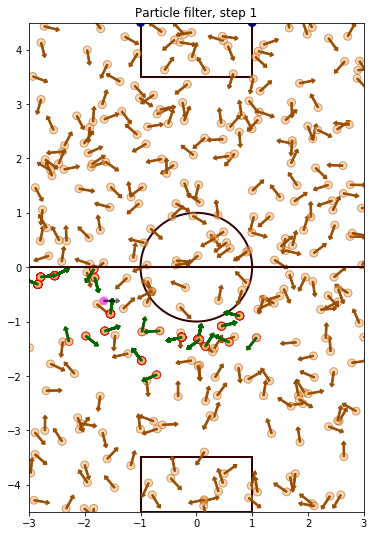

In [1633]:
visualization(robot, 1, p, pre, factor = 7 )

In [1625]:
robot = Robot()
robot.set_coord(-3.0 , 0.0, 0.0)
    

In [1631]:
pf = ParticleFilter(robot, field, sense_noise=1.0)
p = pf.p



In [1632]:
w, pre = pf.resampling()
#robot.update_coord(pre)

prob  6.035451247801345e-158
prob  1.6435414258348106e-124
prob  2.929107233826695e-80
prob  4.9561756388572255e-11
prob  4.048085375123571e-41
prob  1.122054500028516e-25
prob  2.223070321242699e-87
prob  3.300881890820413e-20
prob  5.920865896986723e-44
prob  2.0606187015857367e-25
prob  0.03164018158211428
prob  1.129113354714034e-34
prob  4.913660993546266e-95
prob  2.861086015432977e-124
prob  1.3919256331691253e-104
prob  1.4826503114687051e-77
prob  1.9082566003979181e-13
prob  2.429673684216957e-181
prob  0.021399123546322993
prob  5.558370877006544e-114
prob  6.531000963412154e-40
prob  4.320259613897954e-94
prob  2.561839467465168e-49
prob  7.970789200396473e-13
prob  6.615387399857876e-61
prob  2.654628175682172e-10
prob  2.071552276949659e-74
prob  3.6016308845922584e-131
prob  6.925226048987053e-91
prob  1.9260684595099268e-35
prob  1.0495701265545732e-10
prob  2.889288997819627e-25
prob  1.519517711751776e-107
prob  6.732017874859569e-231
prob  1.4784942441058712e-36
prob

In [1265]:
w, pre = pf.resampling()
robot.update_coord(pre)

z =  [2.6460027951783873]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.6178865382925864]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.575687563411969]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.5036065688342526]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [3.026350367021046]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.9376635539130556]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [3.1578928374082693]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.5739981923722413]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.947349342642156]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.991713116314415]
1.7109

In [785]:
def get_landmarks(fields):
    #landmarks = [[2,1],[4,1],[0,0]]
    landmarks = [[2,1],[2,0],[3,2.5]]
   
    return landmarks

In [1318]:
for i in range (len(pre)):
    print(pre[i][0].x)

5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.553379706693481
5.55337970

In [1392]:
robot1 = Robot()
robot1.set_coord(-2, 3.5, 0.0)

In [1513]:
landmarks = [[-1,4.5],[1,4.5]]


In [1398]:
landmarks_rob = [[1.0, 1.0], [3.0 , 1.0]]

In [1396]:
landmarks_rob - landmarks

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [1394]:
landmarks = landmarks_rob

In [1395]:
z = []
for i in range(len(landmarks)):
    dist = math.sqrt((robot1.x - landmarks1[i][0]) ** 2 + (robot1.y - landmarks1[i][1]) ** 2)
    dist += random.gauss(0.0, robot1.sense_noise)
    angle = robot1.orientation + uangle( landmarks1[i][0] - robot1.x, landmarks1[i][1]-robot1.y, math.cos(robot1.orientation),
                                        math.sin(robot1.orientation))
    #angle += random.gauss(0.0, robot1.sense_noise)
    z.append([dist,angle])


In [764]:
landmarks1[1][1] - robot1.y

-1.0

In [1391]:
z 

[[5.565469110243559, 0.7188299996216245],
 [6.957440769469242, 0.5280744484263596]]

In [1065]:
def uangle(x2,y2,x1 = 0.0,y1 = 1.0):
    return math.acos((x1*x2+y1*y2)/(math.sqrt(x1**2+y1**2)*math.sqrt(x2**2+y2**2)))

In [766]:
uangle(1,1)

0.7853981633974484

In [1376]:
landmarks = z

In [381]:
a = 0.1
b = 0.3
c = 0.2

In [1163]:
landmarks

[[1.710900301849096, 0.7853981633974484],
 [2.9655135183332746, 0.3217505543966423]]

In [383]:
a = a / s
b = b /s
c = c / s


In [1621]:
def get_measurements(landmarks, i):
    x = 0
    y = 0
    x = (landmarks[i][0] - landmarks_rob[i][0] + random.gauss(0.0, 1.5))
    y = ( landmarks[i][1] - landmarks_rob[i][1] + random.gauss(0.0, 1.5))
    return [x,y]

In [1622]:
get_measurements(landmarks, 1)

[-2.653625839096973, 4.976342711515086]

In [1280]:
landmarks

[[1.710900301849096, 0.7853981633974484],
 [2.9655135183332746, 0.3217505543966423]]